In [61]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F

from dinov2.eval.depth.models import build_depther
import urllib

from PIL import Image

class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

In [62]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.to("cpu")
backbone_model.eval()
# backbone_model.cuda()

Using cache found in /Users/ideoghyeon/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [63]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "kitti" # in ("nyu", "kitti")
HEAD_TYPE = "linear4" # in ("linear", "linear4", "dpt")

# kitti + dpt = very slow
# kitti + linear = fast
# kitti + linear4 = similar to linear


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
# model.cuda()

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_kitti_linear4_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (softmax): Softmax(dim=1)
    (conv_depth): Conv2d(3072, 256, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

## Building Pipeline for transform

In [64]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)



## Drone Enviornment Setup


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple
from collections import deque
from replaybuffer import ReplayBuffers
import torch.nn.functional as F

In [66]:
env = UnityEnvironment(file_name= None, base_port=5004)


In [67]:
env.reset()
behavior_names = list(env.behavior_specs.keys())
behavior_name = behavior_names[0]
decision_steps, terminal_steps = env.get_steps(behavior_name)

## Get the length of the space size

In [68]:
# initial states
N_STATES = len(decision_steps.obs[0][0]) + len(decision_steps.obs[1][0])
IMAGE_HEIGHT = 84 # no use in code just here to check the sizes
IMAGE_WIDTH = 84

In [69]:
decision_steps.obs[1][0] # Agent's position (x,y,z) + Target's position (x,y,z)

array([-30.26,   3.42,  -0.67,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  , -30.26,   3.42,  -0.67],
      dtype=float32)

In [70]:
np_camera_image = decision_steps.obs[0][0] # Agent's Camera view
np_camera_image

array([[[0.27450982, 0.2627451 , 0.30588236],
        [0.49411765, 0.6       , 0.74509805],
        [0.49411765, 0.6       , 0.74509805],
        ...,
        [0.5058824 , 0.6156863 , 0.7647059 ],
        [0.50980395, 0.61960787, 0.7647059 ],
        [0.50980395, 0.61960787, 0.7647059 ]],

       [[0.27450982, 0.2627451 , 0.30588236],
        [0.49803922, 0.6039216 , 0.7490196 ],
        [0.49803922, 0.6039216 , 0.7490196 ],
        ...,
        [0.50980395, 0.62352943, 0.76862746],
        [0.5137255 , 0.62352943, 0.76862746],
        [0.5137255 , 0.62352943, 0.77254903]],

       [[0.27450982, 0.2627451 , 0.30588236],
        [0.5019608 , 0.60784316, 0.7529412 ],
        [0.5019608 , 0.60784316, 0.7529412 ],
        ...,
        [0.5137255 , 0.627451  , 0.77254903],
        [0.5137255 , 0.627451  , 0.7764706 ],
        [0.5176471 , 0.627451  , 0.7764706 ]],

       ...,

       [[0.4392157 , 0.60784316, 0.24705882],
        [0.4509804 , 0.62352943, 0.2509804 ],
        [0.44705883, 0

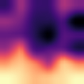

tensor([[46.4520, 46.4520, 46.4520,  ..., 40.4250, 40.4250, 40.4250],
        [46.4520, 46.4520, 46.4520,  ..., 40.4250, 40.4250, 40.4250],
        [46.4520, 46.4520, 46.4520,  ..., 40.4250, 40.4250, 40.4250],
        ...,
        [19.9871, 19.9871, 19.9871,  ..., 20.1432, 20.1432, 20.1432],
        [19.9871, 19.9871, 19.9871,  ..., 20.1432, 20.1432, 20.1432],
        [19.9871, 19.9871, 19.9871,  ..., 20.1432, 20.1432, 20.1432]])


In [71]:
image_tensor = np_camera_image
transform = make_depth_transform() # Apply the transformation pipeline

transformed_image = transform(image_tensor)
# batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image
batch = transformed_image.unsqueeze(0) # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

# Question why is result 3d??
treated_image_2d = result.squeeze().cpu()
depth_image = render_depth(result.squeeze().cpu())
display(depth_image)
print(result.squeeze().cpu())
# treated_image = treated_image_2d.flatten()

In [77]:
action_state = decision_steps.obs[1][0]

In [84]:
flattened_image = treated_image_2d.flatten()

flattened_image
state = np.concatenate((flattened_image,action_state ), 0)
print('Length of Image ', len(state))
print(state)

Length of Image  7071
[ 46.452003  46.452003  46.452003 ... -30.26       3.42      -0.67    ]


In [ ]:
x = decision_steps.obs[0][0]  # Agent's Camera view
y = decision_steps.obs[1][0]  # Agent's position (x,y,z) + Target's position (x,y,z)
state = np.concatenate((x, y), 0)
state

In [ ]:
y

In [ ]:
env.reset()
while True:
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    x = decision_steps.obs[0][0] # Ray Perception 3D
    y = decision_steps.obs[1][0] # Agent's camera
    print(y)
    action = ActionTuple(np.array([0, 0, 1], dtype = np.float32)) # for testing 0,0,1 simultaneuosly
    env.set_actions(behavior_name, action)
    # move the agent along with the action.
    env.step()
    action = action._continuous # converting ActionTuple to array
    next_decision_steps, next_terminal_steps = env.get_steps(behavior_name)

In [85]:
env.close()
# TODO: OpenCV!!!
# Combine the two SAC + DINO2
# 256 x 256 looking good

In [ ]:
get_states()

agent_target_states = [...]
np_camera_image = [[...]]

treated_image = dinov2(np_camera_image) # 384

states_for_training = np.concat(agent_target_states, treated_image)

SAC same
